In [1]:
pip install -q sentence_transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns


In [32]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [33]:
Sentences=\
            [
                'Nothing much to say as it is a macbook. the M1 processor works like a charm',
                'Amazing laptop, super performance with M1, its blazing fast',
                'Working very slow and takes 10-15 minutes to start thus not worth for money',
                'This is not a good laptop. It is very slow. It is taking 20 minutes to start'
            ]

In [34]:
sentence_embeddings = model.encode(Sentences)

In [35]:
for sentence, embedding in zip(Sentences,sentence_embeddings):
  print("Sentence:",sentence)
  print("Embedding:",embedding)
  print("")

Sentence: Nothing much to say as it is a macbook. the M1 processor works like a charm
Embedding: [-2.46487886e-01 -2.08190769e-01 -1.11375332e-01 -1.02352649e-02
 -1.57813817e-01 -3.62281084e-01 -4.32110399e-01  9.86037962e-03
 -1.07506253e-01 -2.81675756e-01  1.49233848e-01  5.82049005e-02
 -4.16482925e-01 -3.29557240e-01  1.99979126e-01 -2.30781838e-01
  4.69206333e-01 -3.71777594e-01  1.01849116e-01  3.07777137e-01
 -1.57086819e-01 -2.26008803e-01  1.97035521e-02  5.11455014e-02
 -4.27458882e-02  5.73056698e-01  6.20062232e-01  6.87860847e-01
 -2.13596374e-01 -2.89903700e-01 -1.45345941e-01  3.32340151e-01
  1.22200347e-01  9.80936959e-02 -1.61606930e-02  3.91541198e-02
  3.21472466e-01 -3.11650723e-01 -4.86470550e-01 -6.87191308e-01
 -2.24826738e-01  6.89011693e-01  5.74313879e-01  5.49121559e-01
  7.78108597e-01  5.74671030e-02 -2.31808469e-01 -2.95517087e-01
  6.50320426e-02 -1.25565559e-01 -2.27927923e-01 -1.22407138e-01
  1.90444648e-01 -8.23580176e-02 -9.82058197e-02  6.479009

In [36]:
len(sentence_embeddings)

4

In [37]:
len(sentence_embeddings[0])

384

In [38]:
pprint('Similarity between {} and {} is {}'.format(Sentences[0],
                                                   Sentences[1],
                                                   cosine_similarity(sentence_embeddings[0].reshape(1,-1),
                                                                     sentence_embeddings[1].reshape(1,-1))[0][0]))

('Similarity between Nothing much to say as it is a macbook. the M1 processor '
 'works like a charm and Amazing laptop, super performance with M1, its '
 'blazing fast is 0.6136190295219421')


In [39]:
pprint('Similarity between {} and {} is {}'.format(Sentences[0],
                                                   Sentences[2],
                                                   cosine_similarity(sentence_embeddings[0].reshape(1,-1),
                                                                     sentence_embeddings[2].reshape(1,-1))[0][0]))

('Similarity between Nothing much to say as it is a macbook. the M1 processor '
 'works like a charm and Working very slow and takes 10-15 minutes to start '
 'thus not worth for money is 0.2067633420228958')


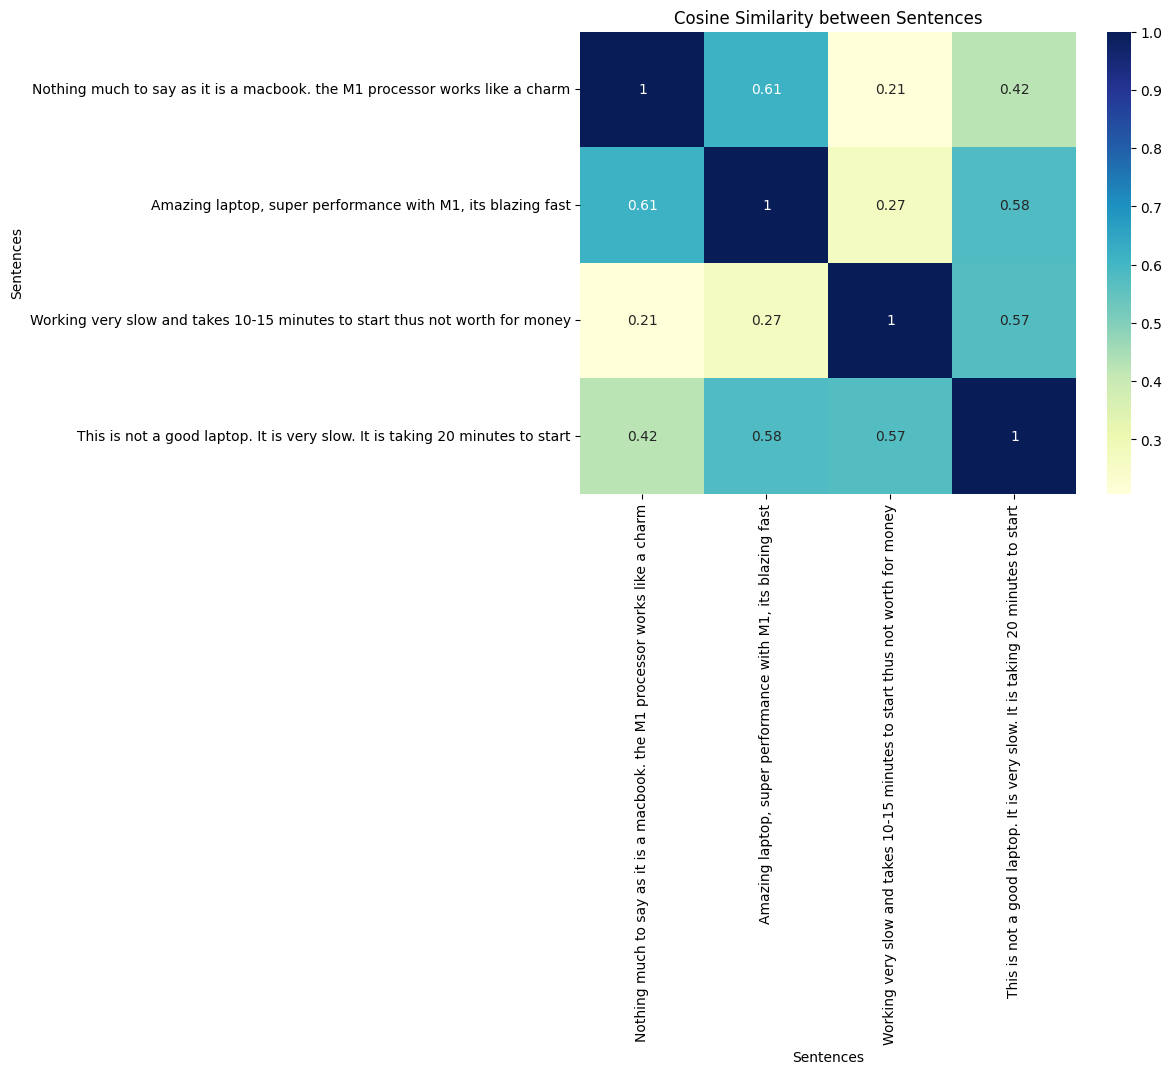

In [40]:
def visualize_similarity(sentences, embeddings):
    cos_sim_matrix = cosine_similarity(embeddings)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cos_sim_matrix, annot=True, cmap='YlGnBu', xticklabels=sentences, yticklabels=sentences)
    plt.title('Cosine Similarity between Sentences')
    plt.xlabel('Sentences')
    plt.ylabel('Sentences')
    plt.show()

# Call the function to visualize similarity
visualize_similarity(Sentences, sentence_embeddings)

Fine-Tuning Starts here


In [41]:
import re
from sentence_transformers import SentenceTransformer, InputExample, SentencesDataset, losses
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [42]:
# Define your fine-tuning dataset with cleaned and tokenized text
fine_tuning_data = [
    ("The cat sat on the mat", "The cat is on the mat", 0.9),
    ("A dog is chasing a ball in the park", "A puppy plays with a ball outside", 0.7),
    ("The weather today is very sunny", "It is raining heavily outside", 0.2),
    ("Artificial intelligence is reshaping industries", "AI is revolutionizing various sectors", 0.8),
    ("Mount Everest is the tallest mountain in the world", "The Eiffel Tower stands tall in Paris", 0.1),
]


In [43]:
# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Remove emojis
    text = re.sub(r":[a-zA-Z0-9_]+:", "", text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text (assuming space-separated tokens)
    tokens = text.split()
    return " ".join(tokens)

In [44]:
# Clean and tokenize the dataset
cleaned_fine_tuning_data = [(clean_and_tokenize(text_a), clean_and_tokenize(text_b), label) for text_a, text_b, label in fine_tuning_data]

In [63]:
fine_tuning_data

[('The cat sat on the mat', 'The cat is on the mat', 0.9),
 ('A dog is chasing a ball in the park',
  'A puppy plays with a ball outside',
  0.7),
 ('The weather today is very sunny', 'It is raining heavily outside', 0.2),
 ('Artificial intelligence is reshaping industries',
  'AI is revolutionizing various sectors',
  0.8),
 ('Mount Everest is the tallest mountain in the world',
  'The Eiffel Tower stands tall in Paris',
  0.1)]

In [45]:
# Format the cleaned dataset into InputExamples
fine_tuning_examples = [InputExample(texts=[text_a, text_b], label=label) for text_a, text_b, label in cleaned_fine_tuning_data]


In [46]:
# Load the pre-trained model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [47]:
# Create a SentencesDataset from the InputExamples
fine_tuning_dataset = SentencesDataset(fine_tuning_examples, model)

In [48]:
# Define the loss function for fine-tuning
fine_tuning_loss = losses.CosineSimilarityLoss(model=model)

In [49]:
# Define a DataLoader for the fine-tuning dataset
fine_tuning_dataloader = DataLoader(fine_tuning_dataset, shuffle=True, batch_size=8)

In [50]:
# Define an evaluator for fine-tuning
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(fine_tuning_examples)


In [51]:
# Fine-tune the model
model.fit(
    train_objectives=[(fine_tuning_dataloader, fine_tuning_loss)],
    epochs=1,
    evaluator=evaluator,
    evaluation_steps=1000,
    output_path="model_finetuned"
)


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
# Save the fine-tuned model
model.save("model_finetuned")

Loading the fine-tuned Model


In [53]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re

In [54]:
# Function to clean and tokenize text
# ensures consistency in preprocessing during both training and inference stages.

def clean_and_tokenize(text):
    # Remove emojis
    text = re.sub(r":[a-zA-Z0-9_]+:", "", text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text (assuming space-separated tokens)
    tokens = text.split()
    return " ".join(tokens)

In [55]:
# Load the fine-tuned model
model = SentenceTransformer('model_finetuned')


In [56]:
# Define the sentences you want to compare
sentences = [
    "The cat sat on the mat.",
    "The cat is on the mat.",
    "A dog is chasing a ball in the park.",
    "A puppy plays with a ball outside.",
    "The weather today is very sunny.",
    "It is raining heavily outside.",
    "Artificial intelligence is reshaping industries.",
    "AI is revolutionizing various sectors.",
    "Mount Everest is the tallest mountain in the world.",
    "The Eiffel Tower stands tall in Paris."
]

In [57]:
# Clean and tokenize the sentences
cleaned_sentences = [clean_and_tokenize(sentence) for sentence in sentences]

In [58]:
# Encode the cleaned sentences using the fine-tuned model
sentence_embeddings = model.encode(cleaned_sentences)

In [59]:
# Print the embeddings
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The cat sat on the mat.
Embedding: [ 5.25705695e-01 -4.71068472e-01 -8.32961798e-02  3.84259701e-01
 -7.49508619e-01  2.93836832e-01 -5.09318709e-03  3.59581292e-01
 -1.75461709e-01  5.55026084e-02  6.33391179e-03  2.43732199e-01
  3.25754493e-01  5.49875319e-01 -4.04969156e-01 -5.55471957e-01
 -2.52564788e-01 -3.16348791e-01 -1.71006843e-01 -6.96800277e-02
  4.07605581e-02 -1.64205313e-01 -1.28719181e-01 -2.55010962e-01
 -4.01035726e-01  1.18967071e-01 -3.39762628e-01 -7.61097819e-02
  2.88702965e-01 -2.80712366e-01 -3.53549451e-01  2.36047417e-01
  6.76801205e-01 -4.04339135e-01 -2.41005495e-01  1.48798898e-01
 -3.14677805e-01 -9.91932228e-02 -4.18793231e-01  2.48332515e-01
 -8.56687501e-02  1.16552956e-01  5.38431406e-01  8.00142251e-03
  5.53986311e-01 -5.66104233e-01  3.45376611e-01 -1.04295850e+00
  2.89412796e-01  5.09124517e-01 -7.14600444e-01  7.98761785e-01
 -1.09218597e-01 -4.55171093e-02 -3.61150980e-01  2.99579948e-01
  4.75455344e-01 -2.92149931e-02  1.28056303e

In [60]:
# Calculate similarity scores between pairs of sentences
similarities = []
for i in range(0, len(sentences), 2):
    similarity = cosine_similarity([sentence_embeddings[i]], [sentence_embeddings[i+1]])[0][0]
    similarities.append(similarity)

In [61]:
# Print the similarity scores
for i in range(len(similarities)):
    print("Similarity between '{}' and '{}' is {:.2f}".format(sentences[2*i], sentences[2*i+1], similarities[i]))

Similarity between 'The cat sat on the mat.' and 'The cat is on the mat.' is 0.92
Similarity between 'A dog is chasing a ball in the park.' and 'A puppy plays with a ball outside.' is 0.70
Similarity between 'The weather today is very sunny.' and 'It is raining heavily outside.' is 0.45
Similarity between 'Artificial intelligence is reshaping industries.' and 'AI is revolutionizing various sectors.' is 0.67
Similarity between 'Mount Everest is the tallest mountain in the world.' and 'The Eiffel Tower stands tall in Paris.' is 0.32


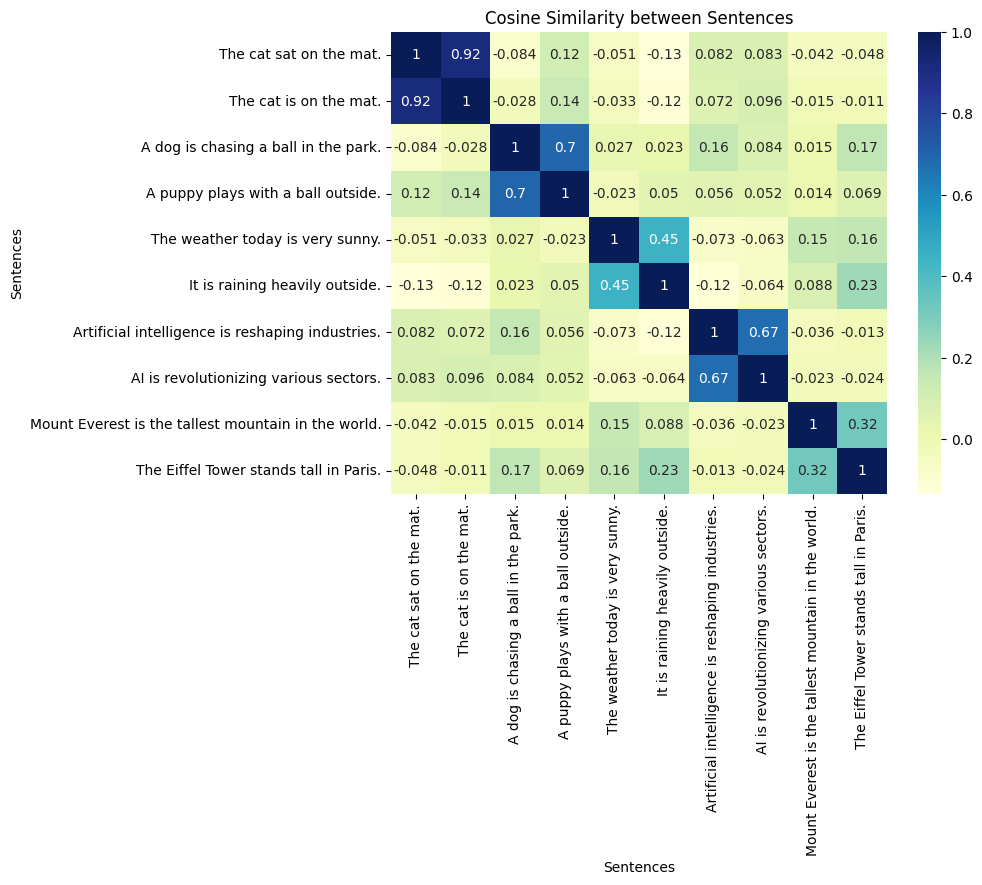

In [62]:
# Call the function to visualize similarity
visualize_similarity(sentences, sentence_embeddings)